# Quantum embeddings

This notebook will take you into some different approaches one may have to encode classical data into a quantum states. 

We will take as a basis the Iris dataset due to its size and being all numeric features.

In [1]:
from sklearn.datasets import load_iris

iris = load_iris()

And create a local simulation mechanism.

In [2]:
from squlearn import Executor

executor = Executor(execution="statevector_simulator")

A common encoding scheme one can use is the ZZ feature map (part of the family of Instantaneous Quantum Polynomial time class and often called the IQP feature map as well). We encode the classical information vector $x$ on a quantum state $|x\rangle$ as

$$

|x\rangle = \left( U_z(x)H^{\otimes n}\right)^r|0\rangle^n,

$$

where $r$ is the depth of the circuit repeating the unitary

$$

U_z(x) = \Pi_{i,j} R_{z,z}(x_i, x_j) \bigotimes_{k=1}^n R_z(x_k)

$$

followed by a layer of $H^{}\otimes n$ at each repetition. This feature maps are used given their complexity when trying to simulate them classically.

References:
* https://arxiv.org/pdf/1804.11326.pdf
* https://arxiv.org/pdf/1504.07999.pdf

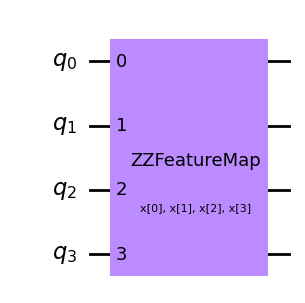

In [3]:
from qiskit.circuit.library import ZZFeatureMap

feature_map = ZZFeatureMap(feature_dimension=4, reps=1, entanglement="linear")
feature_map.draw(output="mpl", style="clifford")

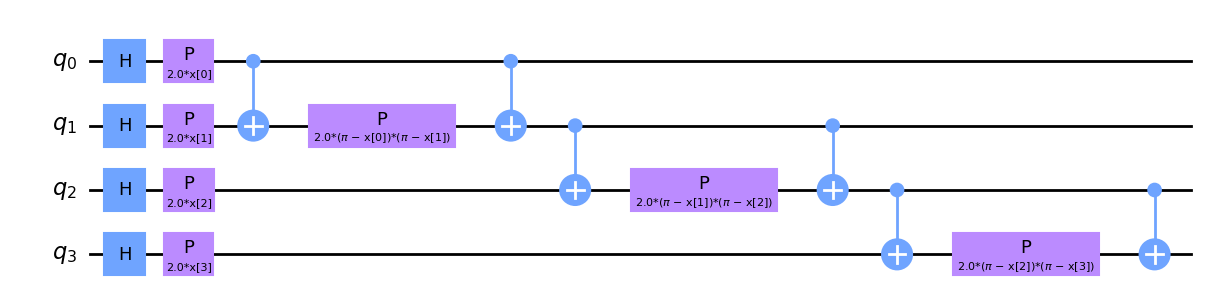

In [4]:
feature_map.decompose(reps=1).draw(output="mpl", style="clifford")

It can be generalized to any other Pauli gate combination of our liking. 

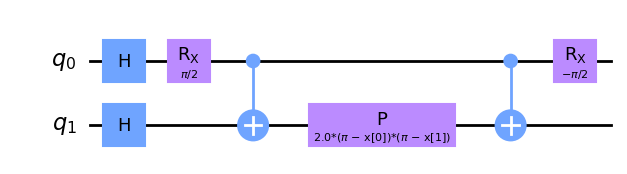

In [5]:
from qiskit.circuit.library import PauliFeatureMap

PauliFeatureMap(2, reps=1, paulis=['ZY']).decompose().draw('mpl', style="clifford")

Once the feature map is build, the kernel needs to be completed depending on our particular selection. In this case, we would like to evaluate the **Fidelity Kernel** therefore the feature map should be inverted for the second input vector ($k(x_1,x_2)$ below).

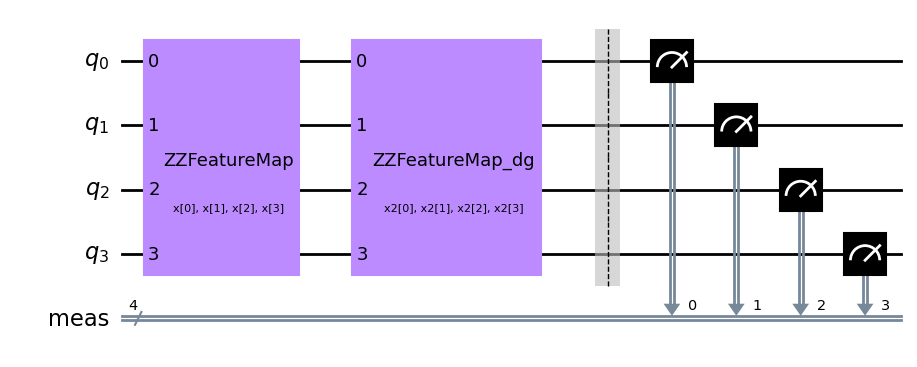

In [6]:
from qiskit.circuit import ParameterVector

# Change parameter names
x2_params = ParameterVector("x2", feature_map.num_parameters)
feature_map_y = feature_map.assign_parameters(x2_params)

fidelity_circ = feature_map.compose(feature_map_y.inverse())
fidelity_circ.measure_all()
fidelity_circ.draw(output="mpl", style="clifford")

In [7]:
X1 = iris.data[0]
X2 = iris.data[1]

print(f"X1 {X1}")
print(f"X2 {X2}")

X1 [5.1 3.5 1.4 0.2]
X2 [4.9 3.  1.4 0.2]


By simply measuring the success probability of the $|0\rangle^{\otimes n}$ state fidelity can be computed.

In [8]:
from qiskit.primitives import Sampler

sampler = Sampler()

bin_probs = sampler.run(fidelity_circ, [*X1, *X1]).result().quasi_dists[0].binary_probabilities()
print(f"K(X1,X1) = {bin_probs['0000']}")

bin_probs = sampler.run(fidelity_circ, [*X2, *X2]).result().quasi_dists[0].binary_probabilities()
print(f"K(X2,X2) = {bin_probs['0000']}")

bin_probs = sampler.run(fidelity_circ, [*X1, *X2]).result().quasi_dists[0].binary_probabilities()
print(f"K(X1,X2) = {bin_probs['0000']}")

K(X1,X1) = 0.9999999999999986
K(X2,X2) = 0.9999999999999986
K(X1,X2) = 0.1061156031155492


This is what essentially Qiskit encapsulates in their Fidelity Quantum Kernel class.

In [9]:
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

fidelity = ComputeUncompute(sampler=sampler)
kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)
kernel.evaluate(X1, X2)

array([[0.1061156]])

In order to introduce our data we will scale it so that each feature scale may not affect its performance.

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler((-1.0,1.0))
X_scaled = scaler.fit_transform(iris.data)

In [11]:
from qiskit.primitives import Estimator
from squlearn.util import Executor
from squlearn.encoding_circuit import QiskitEncodingCircuit
from squlearn.kernel import FidelityKernel
from squlearn.kernel.optimization import TargetAlignment

enc_circ = QiskitEncodingCircuit(feature_map)

k_instance = FidelityKernel(
    encoding_circuit=enc_circ,
    executor=Executor(Estimator()),
    parameter_seed=0
)

# define KTA function
kta = TargetAlignment(quantum_kernel=k_instance)
kta.compute(data=X_scaled, labels=iris.target, parameter_values=None)

-0.3830830241388814

In [12]:
k_instance.evaluate(X_scaled[0], X_scaled[1])

array([[0.00088963]])

In [13]:
iris.target[0] == iris.target[2]

True

That is not a good outcome considering same class features ideally should be placed close to each other. Let's check with a different FM or simply increasing the depth.

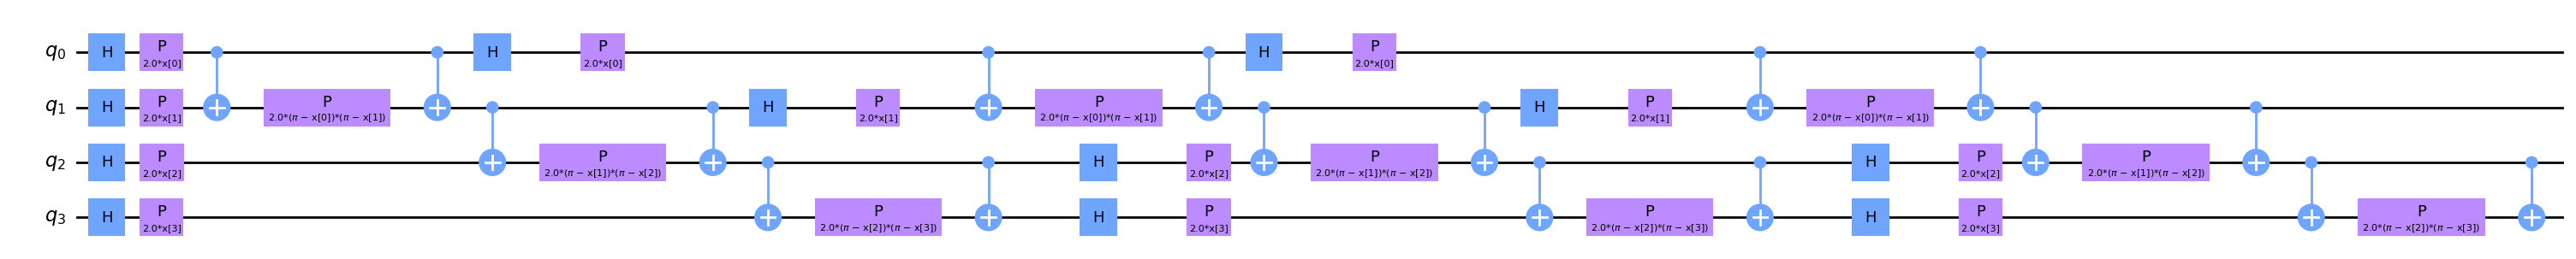

In [14]:
feature_map = ZZFeatureMap(feature_dimension=4, reps=3, entanglement="linear")
feature_map.decompose().draw(output="mpl", style="clifford", fold=-1)

In [15]:
enc_circ = QiskitEncodingCircuit(feature_map)

k_instance_2 = FidelityKernel(
    encoding_circuit=enc_circ,
    executor=Executor(Estimator()),
    parameter_seed=0
)

In [16]:
k_instance_2.evaluate(X_scaled[0], X_scaled[1])

array([[0.08379634]])

Looks like this one gets the outcome closer to what we were expecting.

In [17]:
import numpy as np

idx_0 = np.where(iris.target == 0)
idx_1 = np.where(iris.target == 1)
idx_2 = np.where(iris.target == 2)

In [18]:
intraclass = 0
for idx_0_1, idx_0_2 in zip(idx_0, idx_0):
    intraclass += k_instance.evaluate(X_scaled[idx_0_1], X_scaled[idx_0_2])

np.mean(intraclass)

0.19341053908951386

In [19]:
intraclass = 0
for idx_0_1, idx_0_2 in zip(idx_0, idx_0):
    intraclass += k_instance_2.evaluate(X_scaled[idx_0_1], X_scaled[idx_0_2])

np.mean(intraclass)

0.18535367176172904

Check differences between class 0 and calss 2 samples

In [20]:
interclass = 0
for idx_0_1, idx_2_2 in zip(idx_0, idx_2):
    interclass += k_instance.evaluate(X_scaled[idx_0_1], X_scaled[idx_2_2])

np.mean(interclass)

0.042562144773726704

In [21]:
interclass = 0
for idx_0_1, idx_2_2 in zip(idx_0, idx_2):
    interclass += k_instance_2.evaluate(X_scaled[idx_0_1], X_scaled[idx_2_2])

np.mean(interclass)

0.10898143927091905